# quickcat calibration 

This notebook is the quickcat calibration script.
Its input is a redshift catalog merged with a target list and a truth table from simulations.
Its output is a set of coefficients to be saved in the desisim/py/desisim/data directory (from the desisim github package). 

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
from pkg_resources import resource_filename

from desisim.quickcat import eff_model


def efficiency(x,selection,bins=40) :
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    h1,bins=np.histogram(x[selection],bins=bins)
    ii=(h0>1)
    n=h0[ii]
    meanx=hx[ii]/n
    eff=h1[ii]/n
    err=np.zeros(eff.shape)
    eps=1e-9
    ii=(eff>eps)&(eff<(1-eps))
    err[ii]=np.sqrt(eff[ii]*(1-eff[ii]))/np.sqrt(n[ii])
    ii=(eff<=eps)
    err[ii]=1./np.sqrt(n[ii])
    return meanx,eff,err



def prof(x,y,bins=40) :
    h0,bins=np.histogram(x,bins=bins)
    hx,bins=np.histogram(x,bins=bins,weights=x)
    hy,bins=np.histogram(x,bins=bins,weights=y)
    hy2,bins=np.histogram(x,bins=bins,weights=y**2)
    ii=(h0>1)
    n=h0[ii]
    x=hx[ii]/n
    y=hy[ii]/n
    y2=hy2[ii]/n
    var=y2-y**2
    err=np.zeros(x.size)
    err[var>0]=np.sqrt(var[var>0])
    return x,y,err,n



## Input file 
This input file was copied from NERSC

/project/projectdirs/desi/datachallenge/redwood/spectro/redux/redwood/zcatalog-redwood-target-truth.fits

In [4]:
hdulist = pyfits.open("zcatalog-redwood-target-truth.fits")
table = hdulist["ZCATALOG"].data
print(table.dtype.names)

('TARGETID', 'CHI2', 'COEFF', 'Z', 'ZERR', 'ZWARN', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2', 'BRICKNAME', 'NUMEXP', 'NUMTILE', 'RA', 'DEC', 'MAG', 'BRICKID', 'BRICK_OBJID', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SUBPRIORITY', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'HPXPIXEL', 'MOCKID', 'CONTAM_TARGET', 'TRUEZ', 'TRUESPECTYPE', 'TEMPLATETYPE', 'TEMPLATESUBTYPE', 'TEMPLATEID', 'SEED', 'VDISP', 'OIIFLUX', 'HBETAFLUX', 'TEFF', 'LOGG', 'FEH')


## ELG redshift efficiency 


We assume the ELG redshift efficiency is a function of 
 - the S/N in the emission lines, approximately proportional to OII flux.
 - the S/N in the continuum, approximately proportional to the r-band flux.
 - the redshift

We know that for a given ELG, the  S/N in the lines varies with redshift according to the flux limit defined in the FDR.
So, we will scale the OII flux with this flux limit to account for some of the redshift dependency.
We ignore the evolution of the continuum S/N with redshift for fixed r-band magnitude.


We model the efficiency with an error function,

$ Eff(SNR) = \frac{1}{2} \left( 1+Erf \left( \frac{SNR-3}{b \sqrt{2}} \right) \right) $

with 

$SNR = \sqrt{  \left(  7 \frac{OII flux}{fluxlimit} \right)^2 + \left( a \times rflux \right)^2 }$

$a$ is the continuum $SNR$ normalization, which is proportionnal to the r-band flux.

$b$ is a fudge factor. One would have $b = 1$ if $SNR$ was the variable that determines the redshift efficiency. 

However $SNR$ is only a proxy that is not 100% correlated with the efficiency, so we expect $b>1$.



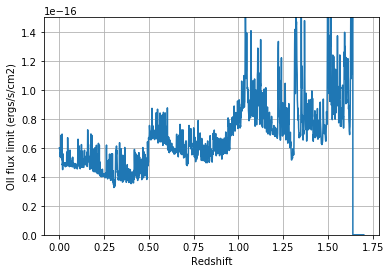

In [136]:
# OII flux limit (FDR), the has-build version should be recomputed but is probably not very different
filename = resource_filename('desisim', 'data/elg_oii_flux_threshold_fdr.txt')
fdr_z, fdr_flux_limit = np.loadtxt(filename, unpack=True)

plt.figure()
plt.plot(fdr_z, fdr_flux_limit)
plt.ylim([0,1.5e-16])
plt.xlabel("Redshift")
plt.ylabel("OII flux limit (ergs/s/cm2)")
plt.grid()

Measured ELG efficiency as a function of rmag and oii flux 

Number of ELGs=28053
(20, 20)


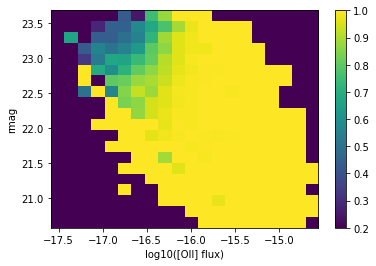

In [137]:
def efficiency2d(x,y,selection,bins=20) :
    h0,xx,yy=np.histogram2d(x,y,bins=bins)
    h1,xx,yy=np.histogram2d(x[selection],y[selection],bins=(xx,yy))
    print(h0.shape)
    nn=(h0+(h0==0)).astype(float)
    eff=h1/nn
    err=np.zeros(eff.shape)
    eps=1e-9
    ii=(eff>eps)&(eff<(1-eps))
    tmp=eff*(1-eff)
    tmp=tmp*(tmp>0)+(tmp==0)
    err=np.sqrt(tmp)/np.sqrt(nn)
    err *= (eff<1)
    return xx,yy,eff,err,nn

######################
elgs=(table["TEMPLATETYPE"]=="ELG")&(table["Z"]>0.6)&(table["Z"]<1.6)
z=table["Z"][elgs]
dz=z-table["TRUEZ"][elgs]
good=(table["ZWARN"][elgs]==0)
rflux=table["FLUX_R"][elgs]
print("Number of ELGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
oiiflux=table["OIIFLUX"][elgs]
oiiflux=oiiflux*(oiiflux>0)+1e-20*(oiiflux<=0)
######################

rmag=-2.5*np.log10(rflux)+22.5
xx,yy,eff,err,nn = efficiency2d(np.log10(oiiflux),rmag,good)
plt.figure()
plt.imshow(eff.T,origin=0,extent=(xx[0],xx[-1],yy[0],yy[-1]),vmin=0.2,aspect="auto")
plt.xlabel("log10([OII] flux)")
plt.ylabel("rmag")
plt.colorbar()

Model

(0.0, 1.4)

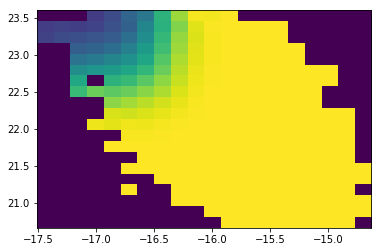

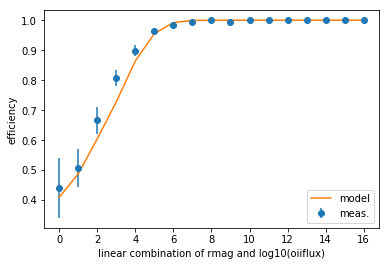

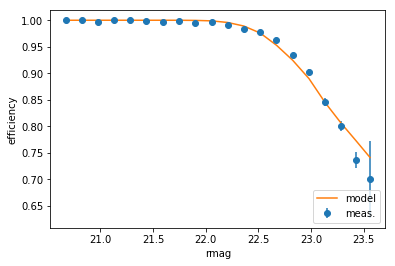

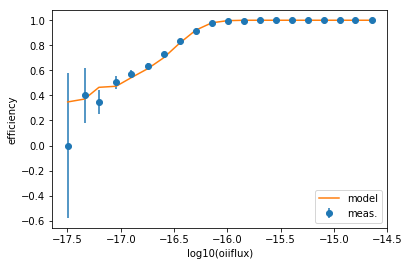

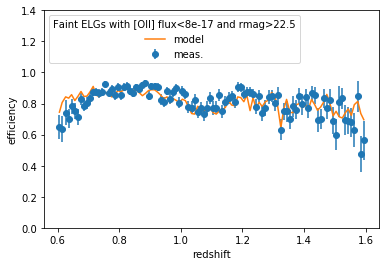

In [141]:
def prof2d(x,y,z,bins=20) :
    h0,xx,yy=np.histogram2d(x,y,bins=bins)
    hz,xx,yy=np.histogram2d(x,y,bins=(xx,yy),weights=z)
    hz2,xx,yy=np.histogram2d(x,y,bins=(xx,yy),weights=z**2)
    n=(h0+(h0==0)).astype(float)
    z=hz/n
    z2=hz2/n
    var=z2-z**2
    err=np.sqrt(var*(var>0))
    x=xx[:-1]+(xx[1]-xx[0])/2.
    y=yy[:-1]+(yy[1]-yy[0])/2.
    return x,y,z,err

# model ELG efficiency vs rflux and oiiflux
oiiflux = table["OIIFLUX"][elgs]
oiiflux = oiiflux*(oiiflux>=0)+0.00001*(oiiflux<=0)
fluxlimit=np.interp(z,fdr_z,fdr_flux_limit)
fluxlimit[fluxlimit<=0]=1e-20
snr_lines=7*oiiflux/fluxlimit
rflux=table["FLUX_R"][elgs]
rflux = rflux*(rflux>=0)+0.00001*(rflux<=0)
snr_cont=rflux/0.21 # to be calibrated
snr=np.sqrt(snr_lines**2+snr_cont**2)

bins=20
fudge=2.2 # WHY ?
meff=0.5*(1.+np.erf((snr-3)/(np.sqrt(2.)*fudge)))
x,y,meff2d,merr=prof2d(np.log10(oiiflux),rmag,meff,bins=bins)

plt.imshow(meff2d.T,origin=0,extent=(x[0],x[-1],y[0],y[-1]),vmin=0.2,aspect="auto")
plt.figure()
i=np.arange(bins)
ok=eff[i,-i]>0
x=np.arange(np.sum(ok))
plt.errorbar(x,eff[i,-i][ok],err[i,-i][ok],fmt="o",label="meas.") #data
plt.plot(x,meff2d[i,-i][ok],"-",label="model") # model
plt.legend(loc="lower right")
plt.xlabel("linear combination of rmag and log10(oiiflux)")
plt.ylabel("efficiency")

plt.figure()
x,eff1d,err1d   = efficiency(rmag,good,bins=bins)
x,meff1d,merr,nn = prof(rmag,meff,bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="lower right")
plt.xlabel("rmag")
plt.ylabel("efficiency")

plt.figure()
x,eff1d,err1d   = efficiency(np.log10(oiiflux),good,bins=bins)
x,meff1d,merr,nn = prof(np.log10(oiiflux),meff,bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="lower right")
plt.xlabel("log10(oiiflux)")
plt.ylabel("efficiency")

plt.figure()
fcut=8e-17
mcut=22.5
s=(oiiflux<fcut)&(rmag>mcut) # select faint ones to increase contrast in z
bins=100
x,eff1d,err1d   = efficiency(z[s],good[s],bins=bins)
x,meff1d,merr,nn = prof(z[s],meff[s],bins=bins)
plt.errorbar(x,eff1d,err1d,fmt="o",label="meas.")
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="upper left",title="Faint ELGs with [OII] flux<{} and rmag>{}".format(fcut,mcut))
plt.xlabel("redshift")
plt.ylabel("efficiency")
plt.ylim([0.,1.4])

## ELG redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of ELGs=28053


Text(0,0.5,'rms dz/(1+z)')

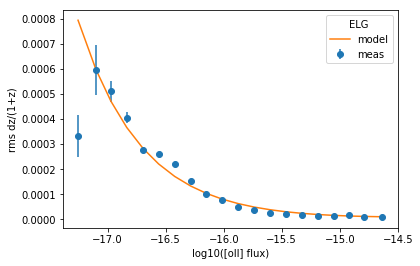

In [154]:
#ELG redshift uncertainty
######################
elgs=(table["TEMPLATETYPE"]=="ELG")&(table["Z"]>0.6)&(table["Z"]<1.6)
z=table["Z"][elgs]
dz=z-table["TRUEZ"][elgs]
good=(table["ZWARN"][elgs]==0)&(np.abs(dz/(1+z))<0.003)
rflux=table["FLUX_R"][elgs]
print("Number of ELGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
oiiflux=table["OIIFLUX"][elgs]
oiiflux=oiiflux*(oiiflux>0)+1e-20*(oiiflux<=0)
lflux=np.log10(oiiflux)
######################

bins=20

binlflux,var,err,nn=prof(lflux[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(binlflux)

## error on var
var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms
c=1.6
a=var[-1]
b=(var[1]-a)*binflux[1]**c
model=np.sqrt(a+b/binflux**c)

#plt.plot(binlflux,rms,"o",label="meas")
plt.errorbar(binlflux,rms,rmserr,fmt="o",label="meas")
plt.plot(binlflux,model,"-",label="model")
plt.legend(loc="upper right",title="ELG")
plt.xlabel("log10([oII] flux)")
plt.ylabel("rms dz/(1+z)")

## LRG redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$



Number of LRGs=21177
eff(rmag=22.5)=0.9829583725486143
a= 26.55610123948563
b= 1.0


Text(0,0.5,'efficiency')

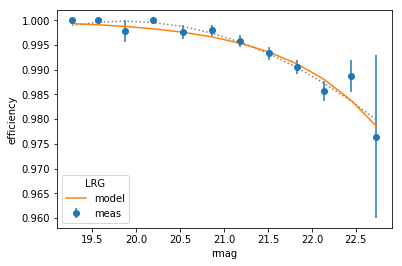

In [146]:
# simply use RFLUX for snr

######################
lrgs=(table["TEMPLATETYPE"]=="LRG")
z=table["Z"][lrgs]
dz=z-table["TRUEZ"][lrgs]
good=(table["ZWARN"][lrgs]==0)
rflux=table["FLUX_R"][lrgs]
print("Number of LRGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
######################


bins=12
x,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(x,eff,err,fmt="o",label="meas")

coef=np.polyfit(x,eff,2)
pol=np.poly1d(coef)
plt.plot(x,pol(x),":",c="gray")
refmag=22.5
measured_eff=pol(refmag)
print("eff(rmag={})={}".format(refmag,measured_eff))
# numerical inversion
refmag=22.5
b=1.
x=np.linspace(0.1,100,1000)
y=1./(1+np.exp((refmag-x)/b))
a=np.interp(measured_eff,y,x)
print("a=",a)
print("b=",b)

meff=1./(1+np.exp((rmag-a)/b))
x,meff1d,merr,nn=prof(rmag,meff,bins=bins)

plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="lower left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("efficiency")
#plt.ylim([0.95,1.03])

## LRG redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of LRGs=21177


Text(0,0.5,'rms dz/(1+z)')

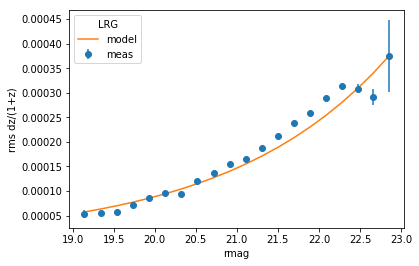

In [149]:
# LRGs redshift uncertainties

######################
lrgs=(table["TEMPLATETYPE"]=="LRG")
z=table["Z"][lrgs]
dz=z-table["TRUEZ"][lrgs]
good=(table["ZWARN"][lrgs]==0)&(np.abs(dz/(1+z))<0.003)
rflux=table["FLUX_R"][lrgs]
print("Number of LRGs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
######################

bins=20

binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))


var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

c=1.1
a=var[0]*0.
b=(var[-1]-a)*binflux[-1]**c
model=np.sqrt(a+b/binflux**c)

#plt.plot(binmag,rms,"o",label="meas")
plt.errorbar(binmag,rms,rmserr,fmt="o",label="meas")
plt.plot(binmag,model,"-",label="model")
plt.legend(loc="upper left",title="LRG")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")

## QSO (z<2) redshift efficiency

Sigmoid function of the r-band magnitude

$Eff = \frac{1}{1+exp (( rmag - a ) / b))}$



Number of QSOs=10201
eff(rmag=22.5)=0.8970828726448702
a= 23.152870386755573
b= 0.3


Text(0,0.5,'efficiency')

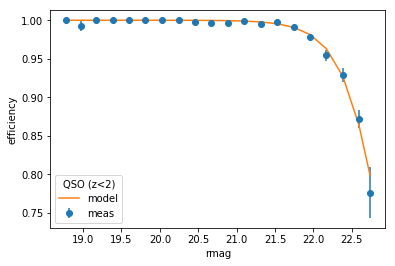

In [100]:
# simply use RFLUX for snr

######################lrg

qsos=(table["TEMPLATETYPE"]=="QSO")&(table["Z"]<2.)
z=table["Z"][qsos]
dz=z-table["TRUEZ"][qsos]
good=(table["ZWARN"][qsos]==0)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
######################


bins=20
x,eff,err=efficiency(rmag,good,bins=bins)
plt.errorbar(x,eff,err,fmt="o",label="meas")
refmag=22.5
measured_eff=np.interp(refmag,x,eff)
print("eff(rmag={})={}".format(refmag,measured_eff))
# numerical inversion
refmag=22.5
b=0.3
x=np.linspace(0.1,100,1000)
y=1./(1+np.exp((refmag-x)/b))
a=np.interp(measured_eff,y,x)
print("a=",a)
print("b=",b)

meff=1./(1+np.exp((rmag-a)/b))
x,meff1d,merr=prof(rmag,meff,bins=bins)
plt.plot(x,meff1d,"-",label="model")
plt.legend(loc="lower left",title="QSO (z<2)")
plt.xlabel("rmag")
plt.ylabel("efficiency")
#plt.ylim([0.95,1.03])

## QSO (z<2) redshift uncertainty

Quadratic sum of an error floor and a flux dependent term.

$rms \left( \frac{dz}{1+z} \right) = \sqrt{a + \frac{b}{rflux^c}}$ 

Number of QSOs=10201


Text(0,0.5,'rms dz/(1+z)')

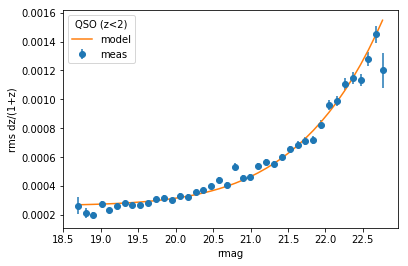

In [164]:
# QSO redshift uncertainties
qsos=(table["TEMPLATETYPE"]=="QSO")&(table["Z"]<2.)
z=table["Z"][qsos]
dz=z-table["TRUEZ"][qsos]
good=(table["ZWARN"][qsos]==0)&(np.abs(dz/(1+z))<0.02)
rflux=table["FLUX_R"][qsos]
print("Number of QSOs={}".format(rflux.size))
rflux=rflux*(rflux>0)+0.00001*(rflux<=0)
rmag=-2.5*np.log10(rflux)+22.5
bins=40

binmag,var,err,nn=prof(rmag[good],((dz/(1+z))**2)[good],bins=bins)
binflux=10**(-0.4*(binmag-22.5))

var_err = np.sqrt(2/nn)*var
rms=np.sqrt(var)
rmserr=0.5*var_err/rms

c=1.7
a=var[0]
b=(var[-2]-a)*binflux[-2]**c
model=np.sqrt(a+b/binflux**c)

#plt.plot(binmag,rms,"o",label="meas")
plt.errorbar(binmag,rms,rmserr,fmt="o",label="meas")
plt.plot(binmag,model,"-",label="model")
plt.legend(loc="upper left",title="QSO (z<2)")
plt.xlabel("rmag")
plt.ylabel("rms dz/(1+z)")